# TensorFlow'a Başlangıç

## TensorFlow Nedir?

[TensorFlow](https://www.tensorflow.org/) verilerin ön işlenmesi, verilerin modellenmesi ve modellerin sunulması (deployment) için açık kaynaklı bir machine learning kütüphanesidir.

## Neden TensorFlow Kullanıyoruz?

Sıfırdan deep learning modelleri oluşturmak yerine TensorFlow gibi bir kütüphane kullanmamız daha mantıklıdır. Bunun nedeni, kullanmak isteyeceğiniz en yaygın fonksiyonların en optimize-vektörize halini içermesidir.

## Bu Notebookta Neler Var?

TensorFlow'u anlatmak için yıllar yetmez, çok geniş bir kütüphanedir. TensorFlow-Lite & TensorFlow-Extended & TensorFlow JS gibi farklı uzantıları vardır. 

Buradaki ana fikir tensörlerle matematiksel işlem yaparak deep learning modelleri oluşturmaktır.

Bu notebookta:
* [TensorFlow ve GPU](#1.kısım)
* [Tensörlere Giriş](#2.kısım)
  * Tensör nedir? Arraylerle temel farkı nedir?
* [Tensörlerin Bilgilerine Erişmek](#3.kısım)
  * shape, rank, size
* [Tensörleri Manipüle Etmek](#4.kısım)
  * Matematiksel işlemler
  * Matris çarpımı
    * `tf.transpose()` ve `tf.reshape()`
    * `tf.matmul()`, `tf.tensordot()` ve `tf.einsum()`
  * Tensör veri tipini değiştirmek
  * İstatistiksel işlemler
  * `assign` ve `add_assign` fonksiyonları
* [Tensörleri Birleştirmek](#5.kısım)
  * `tf.concat()` ve `tf.stack()`
* [Diğer Tensör Operasyonları](#6.kısım)
  * `tf.eye()`, `tf.reverse()`, `tf.roll()` ve `tf.unique_with_counts()`.
* [Tensörler ve Numpy](#7.kısım)
  * Tensörleri np array'e çevirmek
* [TensorFlow Gradient Tape](#99.kısım)
  * TensorFlow ile Gradyan Hesabı
* [@tf.function - AutoGraph](#8.kısım)
  * TF1.X graf objesi ve TF2.X yenilikleri

mevcuttur.



## GPU'lara Erişim Sağlamak
<a id='1.kısım'></a>

Tensörler GPU üzerinde işlem yapabilirler. Tensörün ne olduğuna az sonra değiniyor olacağız. Büyük modeller yazarken GPU ile training yapmak isteyeceğiz, TensorFlow'un da GPU'yu görüp görmediğini [`tf.config.list_physical_devices()`](https://www.tensorflow.org/guide/gpu) fonksiyonu ile kontrol edebiliriz.

In [1]:
import tensorflow as tf
import numpy as np

print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


* `nvidia-smi` ile GPU hakkında daha detaylı bilgiye sahip olabiliriz.

!nvidia-smi # GPU yoksa farklı çıktı görünecektir.

NOT: Eğer GPU kurulu bir environment varsa, TensorFlow varsayılan olarak GPU üzerinde işlemler yapacaktır.
* TF1.X paketlerinde GPU sürümü ayrı olarak install ediliyordu.

## Tensörlere Giriş
<a id='2.kısım'></a>

Vikipediye göre ***tensör'ün*** resmedilmiş hali:
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Components_stress_tensor.svg/1200px-Components_stress_tensor.svg.png" width="500"/>
</div>

Tensörleri **şuan için** Numpy array'i olarak düşünebilirsiniz.

Tensörler herhangi bir şeyi veya sayısal değeri ifade edebilir:
* **Sayıların kendileri olabilir:** Evlerin fiyatını temsil etmek için tensör kullanılabilir.
* **Bir görüntü olabilir:** Bir görüntünün piksellerini temsil etmek için tensörler kullanılabilir.
* **Metin olabilir:** Kelimeleri temsil etmek için tensörler kullanılabilir.
* Veya sayılarla temsil etmek istediğiniz başka bir bilgi veya veri biçimi olabilir.


Tensörler ve NumPy arrayleri (n-boyutlu bir sayı dizisi) arasındaki temel fark, tensörlerin [GPU'larda veya TPU'larda (grafik / tensör işlem birimleri)](https://blogs.nvidia.com/blog/2009/12/) kullanılabilmesidir. 
GPU'larda ve TPU'larda çalışabilmenin yararı daha hızlı hesaplama yapılabilmesidir.
Bu da verilerimizin sayısal olarak temsil ettiği verilerde patternler bulmak istersek (deep learning), genellikle GPU'ları ve TPU'ları kullanarak bunları daha hızlı bulabileceğimiz anlamına gelir.

In [2]:
print(tf.__version__) # 2.7.0

2.7.0


### [`tf.constant()`](https://www.tensorflow.org/api_docs/python/tf/constant) ile Tensörler Oluşturmak

Model oluştururken TensorFlow bizim için çoğu şeyi tensore dönüştürecektir. ([tf.data](https://www.tensorflow.org/guide/data) ve [tf.io](https://www.tensorflow.org/api_docs/python/tf/io))

In [3]:
# Skalar bir tensör oluşturalım
skalar = tf.constant(13)
skalar

<tf.Tensor: shape=(), dtype=int32, numpy=13>

Skalar tensörlerin rankı 0'dır. Çünkü boyutları yoktur, sadece bir sayıdır.

TensorFlow açısından, tensörlerin boyutları için bir sınırlama yoktur. 

In [4]:
# ndim = boyut sayısı (number of dimensions)
skalar.ndim

0

In [5]:
# tf.constant ile vektör oluşturmak, 1 boyutlu
vektör = tf.constant([1, 1])
vektör

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1])>

In [6]:
vektör.ndim

1

In [7]:
# 2 boyutlu, matris
matris = tf.constant([ [1, 1],
                       [1, 1] ])
matris

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 1],
       [1, 1]])>

In [8]:
matris.ndim

2

TensorFlow varsayılan olarak sayısal değerleri `float32` veya `int32` olarak belirler.

In [9]:
# dtype değiştirmek için
matris = tf.constant([[11., 0.],
                              [11., 11.],
                              [11., 11.03]], dtype=tf.float64)
matris

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[11.  ,  0.  ],
       [11.  , 11.  ],
       [11.  , 11.03]])>

In [11]:
matris.ndim

2

In [10]:
# Boyutu aynı kalacaktır
assert matris.ndim == 2

In [12]:
# 3 boyutlu bir tensör
tensör = tf.constant([[ [0, 0, 0],
                        [0, 0, 0] ],
                      
                      [ [0, 0, 0],
                        [1, 1, 1] ],
                      
                      [[1, 1, 1],
                       [1, 1, 1]]])
tensör

<tf.Tensor: shape=(3, 2, 3), dtype=int32, numpy=
array([[[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1]]])>

In [13]:
tensör.ndim

3

#### Resimle özetleyecek olursak:

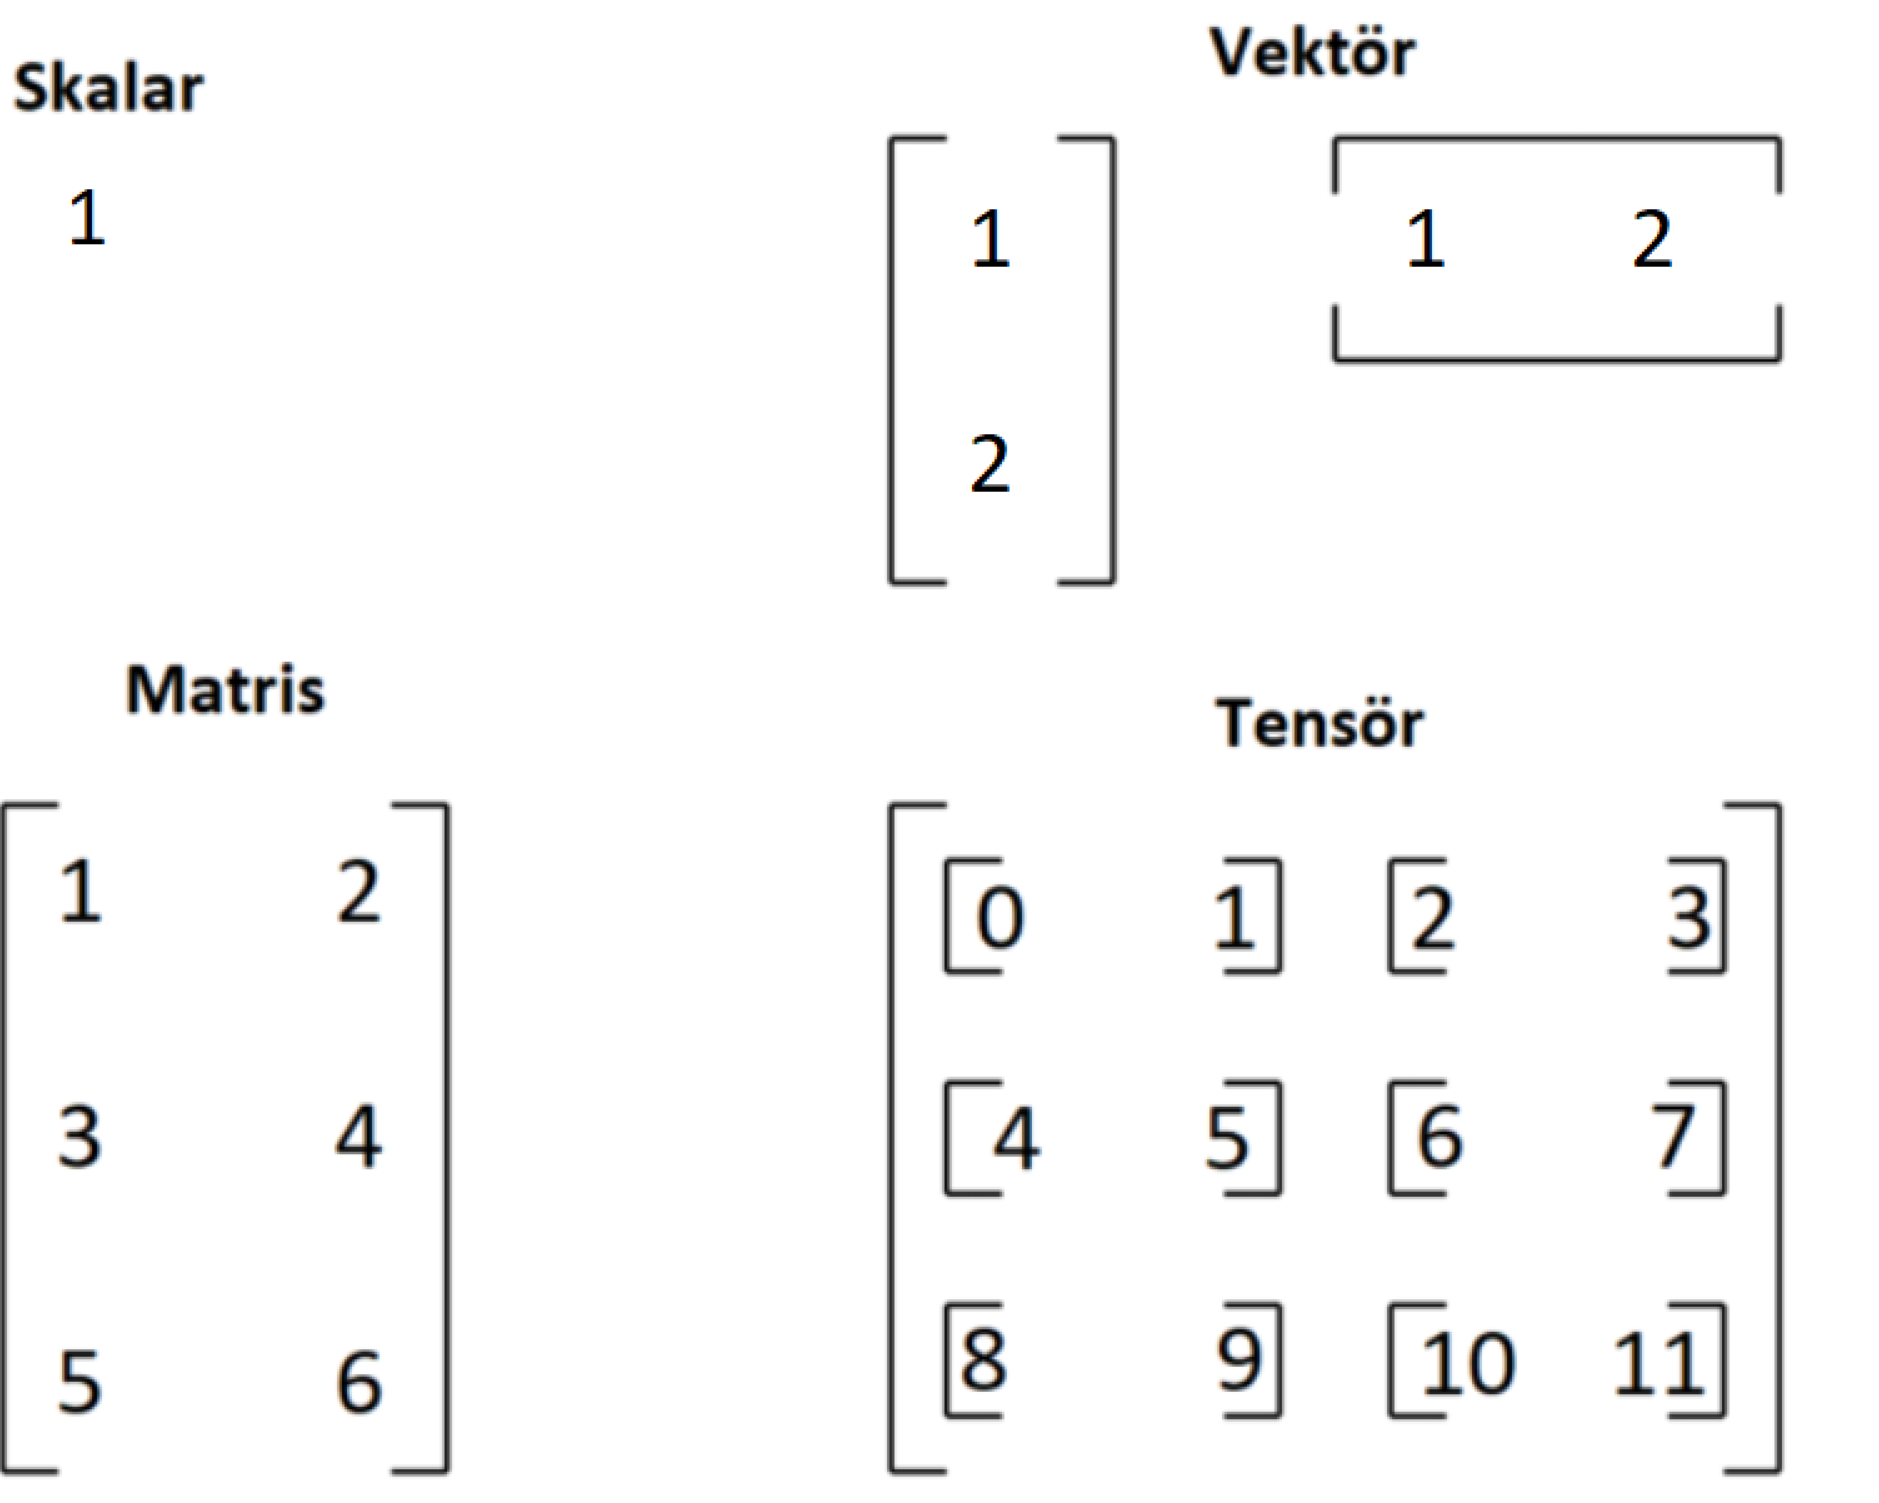

### [`tf.Variable()`](https://www.tensorflow.org/api_docs/python/tf/Variable) ile Tensör Oluşturmak

`tf.Variable` ve `tf.constant`'ın farkı:
* `tf.Variable` mutable --> Değeri değiştirilebilir.
* `tf.constant` immutable --> Değeri sabit kalır, değişmez.

Asıl can alıcı farkına GradientTape kısmında değineceğiz.

In [14]:
# Aynı sayısal tensorler
tf_variable_tensor = tf.Variable([3, 6])
tf_constant_tensor = tf.constant([18, 9])
tf_variable_tensor, tf_constant_tensor

(<tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([3, 6])>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([18,  9])>)

`tf.Variable` ile oluşturan bir tensörun elemanlarını değiştirmek istersek:

In [15]:
# Hata verecektir.
"""
TypeError: 'ResourceVariable' object does not support item assignment
"""
tf_variable_tensor[0] = 13
tf_variable_tensor

TypeError: 'ResourceVariable' object does not support item assignment

`tf.Variable()` ile oluşturulmuş tensörun elemanlarını değiştirmek için [`assign()`](https://www.tensorflow.org/api_docs/python/tf/Variable#assign) metotu kullanılmalıdır.

In [16]:
# Sorunsuz
tf_variable_tensor[0].assign(1)
tf_variable_tensor

<tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([1, 6])>

`tf.constant()` ile oluşmuş tensörün elemanını aynı metot ile değiştirmeye çalışırsak hata alırız.

In [17]:
# tf.constant değişmez
tf_constant_tensor[0].assign(13)
tf_constant_tensor

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'assign'

O zaman biz tensör oluştururken hangisini kullanmalıyız? `tf.constant()` mı yoksa `tf.Variable()` mı?

Bu tür şeyler problem spesifiktir, çoğu zaman model yazarken TensorFlow arka planda bunu bizim için ayarlayacaktır.

### [`tf.random.shuffle`](https://www.tensorflow.org/api_docs/python/tf/random/shuffle) ile Tensör Elemanlarını Karıştırmak

Tensördeki elemanları karıştırmak da çok önemlidir. Deep Learning modelleri overfitting'e çok meyillidir. Herhangi bir etkene bağlı olarak dataya overfit(veriyi ezberleme) olabilirler. Diğer bir yandan,

Misal labelları:

`0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1` olan bir data ele alırsak, tensördeki elemanları karıştırmak önemlidir. Böyle sıralanmış bir veriyi train-test diye ayırırken sınıflar arası dengesizlik oluşturabiliriz.

In [18]:
tensor = tf.constant([[1, 21],
                            [348, 4],
                            [50, 6],
                            [22, 11]])

# Her zaman farklı sonuçlar çıkar.
tf.random.shuffle(tensor)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[  1,  21],
       [ 50,   6],
       [348,   4],
       [ 22,  11]])>

In [19]:
tf.random.shuffle(tensor)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[ 50,   6],
       [348,   4],
       [ 22,  11],
       [  1,  21]])>

In [20]:
# Seed ile aynı şekilde karışır mı?
tf.random.shuffle(tensor, seed=42)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[  1,  21],
       [ 50,   6],
       [ 22,  11],
       [348,   4]])>

In [21]:
tf.random.shuffle(tensor, seed=42)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[348,   4],
       [ 22,  11],
       [ 50,   6],
       [  1,  21]])>

--> `seed` vermemize rağmen shuffle sonuçları farklı çıktı.

[`tf.random.set_seed()`](https://www.tensorflow.org/api_docs/python/tf/random/set_seed) sitesinde yazan 4.bilgiye göre:

> 4) If both the global and the operation seed are set: Both seeds are used in conjunction to determine the random sequence.

`tf.random.set_seed(42)` global seed set ediyor fakat `tf.random.shuffle(seed=13)` fonksiyonundaki `seed` parametresi operasyonel seed set ediyor.

Yine TensorFlow'un sitesinden:
> Operations that rely on a random seed actually derive it from two seeds: the global and operation-level seeds. This sets the global seed.


Yani burada aynı sonuçları istiyorsak operasyonel seedi belirlemek yeterli olmayacaktır. Global seed de ayarlamamız gerekiyor.

In [22]:
# Her zaman aynı sıra ile shuffle etmek istersek

seed = 3398

for _ in range(5):
  # Global seed set et
  tf.random.set_seed(seed)

  # Operasyonel seed et
  print(tf.random.shuffle(tensor, seed=seed)) # seed silmeyi dene?

tf.Tensor(
[[ 22  11]
 [348   4]
 [ 50   6]
 [  1  21]], shape=(4, 2), dtype=int32)
tf.Tensor(
[[ 22  11]
 [348   4]
 [ 50   6]
 [  1  21]], shape=(4, 2), dtype=int32)
tf.Tensor(
[[ 22  11]
 [348   4]
 [ 50   6]
 [  1  21]], shape=(4, 2), dtype=int32)
tf.Tensor(
[[ 22  11]
 [348   4]
 [ 50   6]
 [  1  21]], shape=(4, 2), dtype=int32)
tf.Tensor(
[[ 22  11]
 [348   4]
 [ 50   6]
 [  1  21]], shape=(4, 2), dtype=int32)


### Başka Fonksiyonlarla Tensör Oluşturma

[`tf.ones()`](https://www.tensorflow.org/api_docs/python/tf/ones), [`tf.fill()`](https://www.tensorflow.org/api_docs/python/tf/fill) ve [`tf.zeros()`](https://www.tensorflow.org/api_docs/python/tf/zeros) ile de tensörler oluşturmak mümkündür.

In [23]:
# Tüm elemanları bir olan tensor
tf.ones(shape=(3, 3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

In [24]:
# (2,3) matrisi -1 ile doldur.
tf.fill((2, 3), -1)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[-1, -1, -1],
       [-1, -1, -1]])>

In [25]:
# Tüm elemanları sıfır olan tensor
tf.zeros(shape=(3, 3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

`tf.constant()` kullanarak numpy arraylerini de ayrıca tensörlere dönüştürebiliriz.

Tekrar üzerinden geçmek gerekirse, Numpy array ve TF tensörlerinin farkı, tensörlerin GPU üzerinde çalışıp işlem yapabilmesidir.

Matrisler veya tensörler genelde büyük harflerle isimlendirilir. Vektörler ise küçük harflerle isimlendirilir.

In [26]:
import numpy as np
np_array = np.arange(1, 13)
k = tf.constant(np_array,  
                shape=[2, 3, 2]) # 2 x 3 x 2 = 12
print(np_array) 
print(k) # dtype float64 olmasının sebebi, numpy default.

[ 1  2  3  4  5  6  7  8  9 10 11 12]
tf.Tensor(
[[[ 1  2]
  [ 3  4]
  [ 5  6]]

 [[ 7  8]
  [ 9 10]
  [11 12]]], shape=(2, 3, 2), dtype=int32)


[`tf.convert_to_tensor()`](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor) kullanarak da bu işlemi gerçekleştirebiliriz.

In [27]:
n = tf.convert_to_tensor(np_array) # shape arg yok.
n = tf.reshape(n, [2,3,2]) # reshape edilebilir
n

<tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]]])>

## Tensörlerin Bilgisine Erişmek (shape, rank, size)
<a id='3.kısım'></a>

Tensörlerle ilgili sıklıkla kullanılan terimleri bilmek iyi olacaktır:

* **Shape:** Her dimension'daki element sayısının toplam hali.
* **Rank:** Tensorun sahip olduğu boyut sayısı. Skalar bir sayının `rank`'ı 0, vektörün 1, matrisin 2, tensörun **n** `rank`'ı vardır.
* **Axis** veya **Dimension:** Bir tensörun spesifik bir boyutu.
* **Size:** Tensördeki toplam item sayısı.

`SHAPE` ve `RANK` kavramları model yazarken karşımıza çıkacaktır.

In [28]:
# Rankı 4 olan tensor oluşturalım
tensor_4_rank = tf.ones([2, 3, 4, 6])
tensor_4_rank

<tf.Tensor: shape=(2, 3, 4, 6), dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [29]:
tensor_4_rank.shape, tensor_4_rank.ndim, tf.size(tensor_4_rank), tf.shape(tensor_4_rank)

(TensorShape([2, 3, 4, 6]),
 4,
 <tf.Tensor: shape=(), dtype=int32, numpy=144>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([2, 3, 4, 6])>)

In [30]:
print("Elementlerin veri tipi:", tensor_4_rank.dtype)
print("Boyut sayısı veya rank", tensor_4_rank.ndim)
print("Tensor shape'i :", tensor_4_rank.shape)
print("0.axisteki eleman sayısı:", tensor_4_rank.shape[0])
print("Son axisteki eleman sayısı:", tensor_4_rank.shape[-1])
print("Toplam eleman sayısı:", tf.size(tensor_4_rank).numpy())

Elementlerin veri tipi: <dtype: 'float32'>
Boyut sayısı veya rank 4
Tensor shape'i : (2, 3, 4, 6)
0.axisteki eleman sayısı: 2
Son axisteki eleman sayısı: 6
Toplam eleman sayısı: 144


Tensörleri de aynı python listeleri gibi indexlemek mümkündür.

In [31]:
# Her dimension'dan 2 eleman al.
tensor_4_rank[:2, :2, :2, :2]

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float32, numpy=
array([[[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]],


       [[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]]], dtype=float32)>

In [32]:
# Rank'ı 2 olan tensor
tensor_2_rank = tf.constant([[1, 2],
                             [3, 4]])

# Her satırın son elemanına indexle
tensor_2_rank[:, -1]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 4])>

Tensorlere yeni dimension ekleyebiliriz. Bunun farklı farklı yolları vardır. `tf.newaxis()` ve `tf.expand_dims()` fonksiyonlarına bakalım.

In [33]:
# Sona ekstra dimension ekleyelim.
tensor_3_rank = tensor_2_rank[..., tf.newaxis] # Pythonic

alternatif_3_rank_tensor = tf.expand_dims(tensor_2_rank, axis = -1)

print('Rank 2:', tensor_2_rank, '\n\n') 
print('Rank 3:', tensor_3_rank, '\n\n') 
print('Rank 3 alternatif:', alternatif_3_rank_tensor)

Rank 2: tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 


Rank 3: tf.Tensor(
[[[1]
  [2]]

 [[3]
  [4]]], shape=(2, 2, 1), dtype=int32) 


Rank 3 alternatif: tf.Tensor(
[[[1]
  [2]]

 [[3]
  [4]]], shape=(2, 2, 1), dtype=int32)


## Tensörleri Manipüle Etmek
<a id='4.kısım'></a>


### Dört İşlemler

In [34]:
# Toplama veya çıkarma direkt yapılabilir.
tensör = tf.constant([[14, 28], [42, 56]])
print(id(tensör))

print(id(tensör + 10))
print(tensör + 10)

1533882454608
1533882454960
tf.Tensor(
[[24 38]
 [52 66]], shape=(2, 2), dtype=int32)


`tf.constant()` kullandığımız için orijinal tensor değişmedi. İşlem, tensörün bir kopyasında yapıldı.

In [35]:
# Orijinal Tensor
tensör

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 28],
       [42, 56]])>

Çarpma işlemi de aynı şekilde çalışır.

In [36]:
# Element-Wise çarpma işlemi (Her eleman bağımsız çarpılır)
tensör * 10

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[140, 280],
       [420, 560]])>

In [37]:
# Çıkarma
tensör - 10

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 4, 18],
       [32, 46]])>

Mümkün olduğunca TensorFlow'un implemente ettiği fonksiyonları kullanmak daha iyi bir pratiktir. Bu, TensorFlow'un graphında bir sıkıntı olmaması için gereklidir. TensorFlow, işlemleri takip edebilmek için kendi fonksiyonlarına ihtiyaç duyar. Özellikle gradient hesabında bu kaçınılmazdır.

In [38]:
# TF eşiti fonksiyon
tf.multiply(tensör, 10)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[140, 280],
       [420, 560]])>

In [39]:
# Orijinal tensör değişmez
tensör

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 28],
       [42, 56]])>

### Matris Çarpımı

Temelde matris çarpımı yapmak için 3 tane fonksiyon mevcuttur. Bunlar:
* [`tf.matmul()`](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul)
* [`tf.tensordot()`](https://www.tensorflow.org/api_docs/python/tf/tensordot)
* [`tf.einsum()`](https://www.tensorflow.org/api_docs/python/tf/einsum) -- > Sonra bahsedilecek.

In [40]:
# TF ile matris çarpımı
print(tensör, '\n\n')
print('Matris çarpımı:', tf.matmul(tensör, tensör))

tf.Tensor(
[[14 28]
 [42 56]], shape=(2, 2), dtype=int32) 


Matris çarpımı: tf.Tensor(
[[1372 1960]
 [2940 4312]], shape=(2, 2), dtype=int32)


In [41]:
# Python operatörü ile yapacak olursak
tensör @ tensör

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1372, 1960],
       [2940, 4312]])>

Tensörlerin shapeleri matris çarpımı için müsait olmalıdır.

In [42]:
# (3,2) Tensor
tensor_1 = tf.constant([[10, 20],
                 [30, 40],
                 [50, 60]])

# (3,2) Tensor
tensor_2 = tf.constant([[1, 2],
                 [4, 45],
                 [1, 0]])

print(tensor_1)
print(tensor_2)

tf.Tensor(
[[10 20]
 [30 40]
 [50 60]], shape=(3, 2), dtype=int32)
tf.Tensor(
[[ 1  2]
 [ 4 45]
 [ 1  0]], shape=(3, 2), dtype=int32)


In [43]:
# Matris çarpımı? @ ile pythonda matris çarpımı yapabiliriz
tensor_1 @ tensor_2

InvalidArgumentError: Matrix size-incompatible: In[0]: [3,2], In[1]: [3,2] [Op:MatMul]

Neler Yapılabilir? 
* `tensor_1`'in transpozunu alabiliriz.
* `tensor_2`'nin shape'ini `(2, 3)` olacak şekilde reshape edebiliriz. 

Bunlar için TF hazır fonksiyonları mevcuttur:
* [`tf.reshape()`](https://www.tensorflow.org/api_docs/python/tf/reshape)
* [`tf.transpose()`](https://www.tensorflow.org/api_docs/python/tf/transpose)

In [44]:
# (3, 2) -> (2, 3)
tf.reshape(tensor_2, shape=(2, 3))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 1,  2,  4],
       [45,  1,  0]])>

In [45]:
# Aynı matris çarpımını reshape ile (3, 2) * (2, 3)
tensor_1 @ tf.reshape(tensor_2, shape=(2, 3))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 910,   40,   40],
       [1830,  100,  120],
       [2750,  160,  200]])>

In [46]:
# tensor_1'in transpozu
tf.transpose(tensor_1)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[10, 30, 50],
       [20, 40, 60]])>

In [47]:
# Aynı matris çarpımı transpoz ile (2, 3) (3, 2)
tf.matmul(tf.transpose(tensor_1), tensor_2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 180, 1370],
       [ 240, 1840]])>

In [48]:
# Matmul fonksiyonu ince düşünülmüş bir fonksiyondur.
# Parametre olarak verilen tensörlerin direkt olarak transpozunu alabiliriz.
tf.matmul(a=tensor_1, b=tensor_2, 
          transpose_a=True, transpose_b=False)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 180, 1370],
       [ 240, 1840]])>

### tf.transpose() - perm parametresi

Axislerin yerini değiştirebiliriz.

In [49]:
x = tf.random.normal([2,2,32,3]) # 2, 2, 32, 3
tf.transpose(x).shape

TensorShape([3, 32, 2, 2])

In [50]:
x = tf.random.normal([2, 2, 32, 3, 1])
tf.transpose(x).shape

TensorShape([1, 3, 32, 2, 2])

In [51]:
tf.transpose(x, perm = [0, 3, 2, 1, 4]).shape # (32, 32, 3) 3 --> derinlik rgb (3, 32, 32)

TensorShape([2, 3, 32, 2, 1])

### Dot Product

Matrislerin çarpımı da ayrıca bir dot product işlemini içerir. Yaptığımız matris çarpımını(`tf.matmul()`) ek olarak [`tf.tensordot()`](https://www.tensorflow.org/api_docs/python/tf/tensordot) ile de yapabiliriz.

NOT: Basit işlemler için direkt olarak  `tf.matmul()` kullanmak biraz daha hızlı ve mantıklı olacaktır. Çünkü `tf.matmul()` fonksiyonunun oluşturduğu TensorFlow grafı biraz daha basittir. 

Özetle `tf.matmul()`, `tf.tensordot()` fonksiyonuna göre biraz daha basittir.

#### Tensordot Aslında Nedir?
Tensordot, yüksek boyutlu matrislerde yani tensörlerde verilen axislerde `dot product` yapmaya yarar. Yani Çok boyutlu bir tensörde `dot product` yapmak için `for` döngüleri yazmadan bu işlemi yapabiliriz.

In [52]:
# dot product --> tensordot ile
tf.tensordot(tf.transpose(tensor_1), tensor_2, axes=1)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 180, 1370],
       [ 240, 1840]])>

* Verilen parametreler matris olduğunda `axes = 1` bir olarak belirtirsek bu işlem `tf.matmul()`'a eşit olacaktır.

`reshape` ve `tranpose` metotlarının çalışmasına karşın, farklı sonuçlar aldığımızı farketmişsinizdir.

Biraz irdeleyelim:

In [53]:
# tensor_2 Transpoz ile matris çarpımı sonucu
tf.matmul(tensor_1, tf.transpose(tensor_2))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[  50,  940,   10],
       [ 110, 1920,   30],
       [ 170, 2900,   50]])>

In [54]:
# tensor_2 Reshape ile matris çarpımı sonucu
tf.matmul(tensor_1, tf.reshape(tensor_2, (2, 3)))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 910,   40,   40],
       [1830,  100,  120],
       [2750,  160,  200]])>

İstediğimiz `shape` olmalarına rağmen farklı sonuçlar..


In [55]:
# Shape kontrol et.
print('tensor_2 shape:', tensor_2.shape)
print('tensor_2 - Reshape edildi:', tf.reshape(tensor_2, (2, 3)).shape)
print('tensor_2 Transpoz - Shape:', tf.transpose(tensor_2).shape)

tensor_2 shape: (3, 2)
tensor_2 - Reshape edildi: (2, 3)
tensor_2 Transpoz - Shape: (2, 3)


`reshape` ve `transpoz` matrislerini print edecek olursak:

In [56]:
print("Normal tensor_2:")
print(tensor_2, "\n")

print("tensor_2 reshape edildi --> (2, 3):")
print(tf.reshape(tensor_2, (2, 3)), "\n")

print("tensor_2 transpoz edilince:")
print(tf.transpose(tensor_2))

Normal tensor_2:
tf.Tensor(
[[ 1  2]
 [ 4 45]
 [ 1  0]], shape=(3, 2), dtype=int32) 

tensor_2 reshape edildi --> (2, 3):
tf.Tensor(
[[ 1  2  4]
 [45  1  0]], shape=(2, 3), dtype=int32) 

tensor_2 transpoz edilince:
tf.Tensor(
[[ 1  4  1]
 [ 2 45  0]], shape=(2, 3), dtype=int32)


`Shape`'ler aynı olması rağmen, numerik olarak farklı değerlere karşılık geliyorlar.

Bunu şu şekilde açıklayabiliriz:
* [`tf.reshape()`](https://www.tensorflow.org/api_docs/python/tf/reshape) - 
İlk başta verilen tensörün `shape`'ini değiştiriyor, ondan sonra göründüğü sıra ile yeni tensör `shape`'ine dolduruyor..

* [`tf.transpose()`](https://www.tensorflow.org/api_docs/python/tf/transpose) - 
eksenlerin sırasını değiştiriyor, son eksen varsayılan olarak ilk eksen olarak atanıyor. `perm` parametresi ile sırası değiştirilebilir. `perm` parametresine ilerleyen bölümde değineceğiz

Hangisini Kullanmalıyız?

Çoğu zaman matris çarpımında shape'ler uyuşmaz ise, transpoz alarak ilerleyeceğiz.

### Tensörun Veri Tipini Değiştirmek

[`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast) fonksiyonu ile tensorun içinde bulunan elementlerin veri tipini dğeiştirebiliriz.

In [57]:
# Varsayılan dtype ile tensor
tensör = tf.constant([1.7, 7.4])

print('Tensör:', tensör)

Tensör: tf.Tensor([1.7 7.4], shape=(2,), dtype=float32)


In [58]:
# Float16'ya cast edelim
tensör = tf.cast(tensör, dtype=tf.float16)
print("Float16'ya cast edildi:", tensör)

Float16'ya cast edildi: tf.Tensor([1.7 7.4], shape=(2,), dtype=float16)


In [59]:
# Int32'den Float32
tensör = tf.cast(tensör, dtype=tf.float32)
print("Float32'ya cast edildi:", tensör)

Float32'ya cast edildi: tf.Tensor([1.7001953 7.3984375], shape=(2,), dtype=float32)


### Tensörün Mutlak Değeri
[`tf.abs()`](https://www.tensorflow.org/api_docs/python/tf/math/abs) ile tensörün sıfırdan küçük elemanlarını pozitif hale getirebiliriz. Yani mutlak değerini alabiliriz.

In [60]:
# Negatif değerli tensor
tensör = tf.constant([-13, -3])
print("Mutlak değeri alınan tensör:", tf.math.abs(tensör))
# tf.abs -- tf.math.abs --> ALIAS

Mutlak değeri alınan tensör: tf.Tensor([13  3], shape=(2,), dtype=int32)


### Kare Alma, Logaritma, Karekök

Matematiksel yapmak isteyeceğiniz çoğu fonksiyonun zaten TF içinde implementasyonu mevcut olacaktır.

* [`tf.square()`](https://www.tensorflow.org/api_docs/python/tf/math/square) - Her elemanın karesini al.
* [`tf.sqrt()`](https://www.tensorflow.org/api_docs/python/tf/math/sqrt) - Elemanların karekökünü al. (float gerekli)
* [`tf.math.log()`](https://www.tensorflow.org/api_docs/python/tf/math/log) - e tabanında log'a eşittir = Ln(x)

In [61]:
# Yeni Tensor
tensör = tf.constant(tf.range(1, 10))
tensör

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8, 9])>

In [62]:
# Karesini al
tf.square(tensör)

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])>

In [63]:
# Karekök, int ile hata verir.
tf.sqrt(tensör)

InvalidArgumentError: Value for attr 'T' of int32 is not in the list of allowed values: bfloat16, half, float, double, complex64, complex128
	; NodeDef: {{node Sqrt}}; Op<name=Sqrt; signature=x:T -> y:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128]> [Op:Sqrt]

In [64]:
# float32'ye cast edersek
tensör = tf.cast(tensör, dtype=tf.float32)
tensör

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)>

In [65]:
# Karekök al
tf.sqrt(tensör)

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.       , 1.4142135, 1.7320508, 2.       , 2.2360678, 2.4494896,
       2.6457512, 2.828427 , 3.       ], dtype=float32)>

In [66]:
# Ln al
tf.math.log(tensör)

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.       , 0.6931472, 1.0986123, 1.3862944, 1.609438 , 1.7917595,
       1.9459102, 2.0794415, 2.1972246], dtype=float32)>

### Minimum, Maksimum, Ortalama ve Toplam Değerleri

* [`tf.reduce_min()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_min) - Minimum değer fonksiyonu.
* [`tf.reduce_max()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max) - Maksimum değer fonksiyonu.
* [`tf.reduce_mean()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean) - Tensordeki tüm elemanların ortalaması (axis verilmemiş ise)
* [`tf.reduce_sum()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) - Tensordeki tüm elemanların ortalaması. (axis verilmemiş ise)


Bu fonksiyonlar genelde `tf.math` modulü altındadır fakat onları direkt çağırmak da yeterlidir. (alias)

In [67]:
# Random Değerli Tensor
tensor = tf.constant(np.random.randint(low=0, high=1000, size=10))
tensor

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([615, 309, 213, 616, 209, 324, 707,  25, 330, 474])>

In [68]:
# Minimum değeri bul
tf.reduce_min(tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=25>

In [69]:
# Maksimum değeri bul
tf.reduce_max(tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=707>

In [70]:
# Ortalama değeri bul
tf.reduce_mean(tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=382>

In [71]:
# Toplam değeri bul
tf.reduce_sum(tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=3822>

### Tensörlerde İşlemlere Örnekler ve Özet


In [72]:
# Skalerdir. Shape: ()
x = 2
tf_x = tf.constant(x)
print('x:', x)
print('tf_x:', tf_x)
print('tf_x type:', type(tf_x))

x: 2
tf_x: tf.Tensor(2, shape=(), dtype=int32)
tf_x type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [73]:
# Vektör yapmak için [x] yapmamız yeterlidir. Shape: (1, )
x = 2
tf_x = tf.constant([x])
print('x:', x)
print('tf_x:', tf_x)
print('tf_x type:', type(tf_x))

x: 2
tf_x: tf.Tensor([2], shape=(1,), dtype=int32)
tf_x type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [74]:
# Başka bir vektör.
x = 2
tf_x = tf.constant([x, x-1])
print('x:', x)
print('tf_x:', tf_x)
print('tf_x type:', type(tf_x))

x: 2
tf_x: tf.Tensor([2 1], shape=(2,), dtype=int32)
tf_x type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [75]:
# Matris oluşturma Shape: (2, 2)
x = 2
tf_x = tf.constant([ [x, x-1], [x+1, x+2] ])
print('x:', x)
print('tf_x:', tf_x)
print('tf_x type:', type(tf_x))

x: 2
tf_x: tf.Tensor(
[[2 1]
 [3 4]], shape=(2, 2), dtype=int32)
tf_x type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [76]:
# Tensör oluşturma
x = 2
tf_x = tf.constant([ [ [x, x-1], [x+1, x+2] ], 
                    [ [x, x*2], [x*3, x*4] ],
                    [ [x, x/2], [x/8, x/4] ]])
print('x:', x)
print('tf_x:', tf_x)
print('tf_x type:', type(tf_x))

x: 2
tf_x: tf.Tensor(
[[[2.   1.  ]
  [3.   4.  ]]

 [[2.   4.  ]
  [6.   8.  ]]

 [[2.   1.  ]
  [0.25 0.5 ]]], shape=(3, 2, 2), dtype=float32)
tf_x type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [77]:
# Slicing
x = tf.constant([ [1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9] ])
# print('x = ', x)
print('\nx[0, :] = ', x[0, :])
print('\nx[:, 0] = ', x[:, 0])
print('\nx[0:2, 0:2] = ', x[0:2, 0:2])
print('\nx + x[0, :] = ', x + x[0, :])


x[0, :] =  tf.Tensor([1 2 3], shape=(3,), dtype=int32)

x[:, 0] =  tf.Tensor([1 4 7], shape=(3,), dtype=int32)

x[0:2, 0:2] =  tf.Tensor(
[[1 2]
 [4 5]], shape=(2, 2), dtype=int32)

x + x[0, :] =  tf.Tensor(
[[ 2  4  6]
 [ 5  7  9]
 [ 8 10 12]], shape=(3, 3), dtype=int32)


In [78]:
# Element-Wise İşlemler
print('x + x = ', x + x)
print('\nx * x = ', x * x)
print('\nx - x = ', x - x)
print('\nx / x = ', x / x)
print('\nx * 2 = ', x * 2)

x + x =  tf.Tensor(
[[ 2  4  6]
 [ 8 10 12]
 [14 16 18]], shape=(3, 3), dtype=int32)

x * x =  tf.Tensor(
[[ 1  4  9]
 [16 25 36]
 [49 64 81]], shape=(3, 3), dtype=int32)

x - x =  tf.Tensor(
[[0 0 0]
 [0 0 0]
 [0 0 0]], shape=(3, 3), dtype=int32)

x / x =  tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]], shape=(3, 3), dtype=float64)

x * 2 =  tf.Tensor(
[[ 2  4  6]
 [ 8 10 12]
 [14 16 18]], shape=(3, 3), dtype=int32)


In [79]:
# (2, 3) şeklinde tensor.
x = tf.constant([[1, 2, 1], 
                 [8, 10, -6]], dtype = tf.float32)

#  (3, 2) şeklinde tensor.
y = tf.constant([[7, 8], 
                 [9, 10], 
                 [11, 12]], dtype = tf.float32)

print('x:', x)
print('\ny:', y)

x: tf.Tensor(
[[ 1.  2.  1.]
 [ 8. 10. -6.]], shape=(2, 3), dtype=float32)

y: tf.Tensor(
[[ 7.  8.]
 [ 9. 10.]
 [11. 12.]], shape=(3, 2), dtype=float32)


In [80]:
# (2, 3) --> (3, 2)
x = tf.transpose(x, perm = [1, 0])
print('Transposed: ', x)
print('\ny:', y)

print('\nx + y = ', x + y)
print('\nx * y = ', x * y)
print('\nx - y = ', x - y)
print('\nx / y = ', x / y)

Transposed:  tf.Tensor(
[[ 1.  8.]
 [ 2. 10.]
 [ 1. -6.]], shape=(3, 2), dtype=float32)

y: tf.Tensor(
[[ 7.  8.]
 [ 9. 10.]
 [11. 12.]], shape=(3, 2), dtype=float32)

x + y =  tf.Tensor(
[[ 8. 16.]
 [11. 20.]
 [12.  6.]], shape=(3, 2), dtype=float32)

x * y =  tf.Tensor(
[[  7.  64.]
 [ 18. 100.]
 [ 11. -72.]], shape=(3, 2), dtype=float32)

x - y =  tf.Tensor(
[[ -6.   0.]
 [ -7.   0.]
 [-10. -18.]], shape=(3, 2), dtype=float32)

x / y =  tf.Tensor(
[[ 0.14285715  1.        ]
 [ 0.22222222  1.        ]
 [ 0.09090909 -0.5       ]], shape=(3, 2), dtype=float32)


In [81]:
print('tf.add(x, y) = ', tf.add(x, y))
print('\ntf.multiply(x, y) = ', tf.multiply(x, y))
print('\ntf.subtract(x, y) = ', tf.subtract(x, y))
print('\ntf.divide(x, y) = ', tf.divide(x, y))

tf.add(x, y) =  tf.Tensor(
[[ 8. 16.]
 [11. 20.]
 [12.  6.]], shape=(3, 2), dtype=float32)

tf.multiply(x, y) =  tf.Tensor(
[[  7.  64.]
 [ 18. 100.]
 [ 11. -72.]], shape=(3, 2), dtype=float32)

tf.subtract(x, y) =  tf.Tensor(
[[ -6.   0.]
 [ -7.   0.]
 [-10. -18.]], shape=(3, 2), dtype=float32)

tf.divide(x, y) =  tf.Tensor(
[[ 0.14285715  1.        ]
 [ 0.22222222  1.        ]
 [ 0.09090909 -0.5       ]], shape=(3, 2), dtype=float32)


In [82]:
x.__add__(y)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 8., 16.],
       [11., 20.],
       [12.,  6.]], dtype=float32)>

In [83]:
print(x)

print('\ntf.reduce_sum(x, None) = ', tf.reduce_sum(x, None))

print('\ntf.reduce_sum(x, 0) = ', tf.reduce_sum(x, axis = 0))
print('\n x[:, 0]', x[:, 0])
print('\n x[:, 1]', x[:, 1])
print('---' * 35)
print('\ntf.reduce_sum(x, 1) = ', tf.reduce_sum(x, 1))
print('\n x[0, :]', x[0, :])
print('\n x[1, :]', x[1, :])
print('\n x[2, :]', x[2, :])
print('---' * 35)

print('\ntf.reduce_sum(x, [0,1]) = ', tf.reduce_sum(x, [0,1])) # Önce satırları, sonucun kolonlarını
print('\ntf.reduce_sum(x, [1,0]) = ', tf.reduce_sum(x, [1,0]))
print('---' * 35)
print('\ntf.reduce_mean(x) = ', tf.reduce_mean(x))
print('\ntf.reduce_mean(x, 0) = ', tf.reduce_mean(x, 0))
print('\ntf.reduce_mean(x, 1) = ', tf.reduce_mean(x, 1))
print('\ntf.reduce_mean(x, [0, 1]) = ', tf.reduce_mean(x, [0, 1]))

tf.Tensor(
[[ 1.  8.]
 [ 2. 10.]
 [ 1. -6.]], shape=(3, 2), dtype=float32)

tf.reduce_sum(x, None) =  tf.Tensor(16.0, shape=(), dtype=float32)

tf.reduce_sum(x, 0) =  tf.Tensor([ 4. 12.], shape=(2,), dtype=float32)

 x[:, 0] tf.Tensor([1. 2. 1.], shape=(3,), dtype=float32)

 x[:, 1] tf.Tensor([ 8. 10. -6.], shape=(3,), dtype=float32)
---------------------------------------------------------------------------------------------------------

tf.reduce_sum(x, 1) =  tf.Tensor([ 9. 12. -5.], shape=(3,), dtype=float32)

 x[0, :] tf.Tensor([1. 8.], shape=(2,), dtype=float32)

 x[1, :] tf.Tensor([ 2. 10.], shape=(2,), dtype=float32)

 x[2, :] tf.Tensor([ 1. -6.], shape=(2,), dtype=float32)
---------------------------------------------------------------------------------------------------------

tf.reduce_sum(x, [0,1]) =  tf.Tensor(16.0, shape=(), dtype=float32)

tf.reduce_sum(x, [1,0]) =  tf.Tensor(16.0, shape=(), dtype=float32)
------------------------------------------------------------------

In [84]:
# Matris İşlemleri İçin Transpoz alalım.
x = tf.transpose(x)
x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  2.,  1.],
       [ 8., 10., -6.]], dtype=float32)>

In [85]:
y

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 7.,  8.],
       [ 9., 10.],
       [11., 12.]], dtype=float32)>

In [86]:
print('x:', x)
print('\ny:', y)

print('\ntf.matmul(x, y) = ', tf.matmul(x, y))
print('---' * 30)
# Axes 0: X'in her elemanı ve y'nin her elemanı dot-product'a tabi tutulur.
print('\ntf.tensordot(x, y, axes=0) = ', tf.tensordot(x, y, axes=0))

# Axes = 1, X'in son axis'indeki her eleman, y'nin ilk axisindeki her eleman alınır, vektörler dot-product'a tabi tutulur.
print('\ntf.tensordot(x, y, axes=1) = ', tf.tensordot(x, y, axes=1))
print('\ntf.tensordot(x, y, axes=2) = ', tf.tensordot(x, y, axes=2))
print('---' * 30)

print('\ntf.einsum("ij,jk->ik", x, y) = ', tf.einsum("ij,jk->ik", x, y))

x: tf.Tensor(
[[ 1.  2.  1.]
 [ 8. 10. -6.]], shape=(2, 3), dtype=float32)

y: tf.Tensor(
[[ 7.  8.]
 [ 9. 10.]
 [11. 12.]], shape=(3, 2), dtype=float32)

tf.matmul(x, y) =  tf.Tensor(
[[36. 40.]
 [80. 92.]], shape=(2, 2), dtype=float32)
------------------------------------------------------------------------------------------

tf.tensordot(x, y, axes=0) =  tf.Tensor(
[[[[  7.   8.]
   [  9.  10.]
   [ 11.  12.]]

  [[ 14.  16.]
   [ 18.  20.]
   [ 22.  24.]]

  [[  7.   8.]
   [  9.  10.]
   [ 11.  12.]]]


 [[[ 56.  64.]
   [ 72.  80.]
   [ 88.  96.]]

  [[ 70.  80.]
   [ 90. 100.]
   [110. 120.]]

  [[-42. -48.]
   [-54. -60.]
   [-66. -72.]]]], shape=(2, 3, 3, 2), dtype=float32)

tf.tensordot(x, y, axes=1) =  tf.Tensor(
[[36. 40.]
 [80. 92.]], shape=(2, 2), dtype=float32)

tf.tensordot(x, y, axes=2) =  tf.Tensor(150.0, shape=(), dtype=float32)
------------------------------------------------------------------------------------------

tf.einsum("ij,jk->ik", x, y) =  tf.Tensor(
[[36.

In [87]:
# (2, 2) şeklinde tensor.
# Axes = 2, x'in son iki axisini, y'nin ilk iki axisini alıp çarpmaktır.
x = tf.constant([[1, 2], 
                 [8, 10]], dtype = tf.float32)

#  (2, 2) şeklinde tensor.
y = tf.constant([[7, 8], 
                 [9, 10]], dtype = tf.float32)

print('\ntf.tensordot(x, y, axes=2) = ', tf.tensordot(x, y, axes=2))


tf.tensordot(x, y, axes=2) =  tf.Tensor(195.0, shape=(), dtype=float32)


In [88]:
print('x:', x)
print('\ny:', y)

tf.multiply(x, y)

x: tf.Tensor(
[[ 1.  2.]
 [ 8. 10.]], shape=(2, 2), dtype=float32)

y: tf.Tensor(
[[ 7.  8.]
 [ 9. 10.]], shape=(2, 2), dtype=float32)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[  7.,  16.],
       [ 72., 100.]], dtype=float32)>

In [89]:
tf.reduce_sum(tf.multiply(x, y), axis = None)

<tf.Tensor: shape=(), dtype=float32, numpy=195.0>

Ayrıca farklı olarak, [`tf.math.reduce_std()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_std) ve [`tf.math.reduce_variance()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_variance) fonksiyonları da mevcuttur.

### Tensördeki Maksimum / Minimum Değerin İndexini Bulmak

--> Deep Learning modelleri yazarken probleme göre çıktı katmanında farklı aktivasyon fonksiyonları kullanacağız. Kısaca bahsetmek gerekirse, aktivasyon fonksiyonları deep learning modellerinin lineer olmayan ilişkileri öğrenmesini sağlar. Bunlara daha sonraları tekrar değiniyor olacağız.

Deep learning modelleri bize toplamı 1 olacak şekilde çıktılar verebilir. `Softmax` aktivasyon fonksiyonu buna örnektir. 3 tane sınıfımız olduğunu düşünürsek, model çıktısı şöyle olabilir: `[0.1, 0.6, 0.3]`. Buradaki maksimum sayının indeksi bize tahmin edilen sınıfı verecektir. O indeksi `tf.argmax()` ile alabiliriz.

* [`tf.argmax()`](https://www.tensorflow.org/api_docs/python/tf/math/argmax) - Tensördeki maximum elementin bulunduğu indeks.
* [`tf.argmin()`](https://www.tensorflow.org/api_docs/python/tf/math/argmin) - Tensördeki minimum elementin bulunduğu indeks.

In [90]:
# Random Tensor
tensor = tf.math.softmax(tf.constant(np.random.random(3)))
tensor

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.30303991, 0.40651212, 0.29044797])>

In [91]:
# Maks Element İndex, bir skalar döndürüyor.
tf.argmax(tensor)

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [92]:
# Min Element İndex
tf.argmin(tensor)

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [93]:
# Find the maximum element position of F
print(f"Tensordeki maksimum elementin bulunduğu index: {tf.argmax(tensor).numpy()}") 
print(f"Tensorun içerdiği maximum element: {tf.reduce_max(tensor).numpy()}") 
print(f"Argmax ile maksimum elemanı bulmak: {tensor[tf.argmax(tensor)].numpy()}")
print(f"Sanity Check Yaparsak:) --> {tensor[tf.argmax(tensor)].numpy() == tf.reduce_max(tensor).numpy()}")

Tensordeki maksimum elementin bulunduğu index: 1
Tensorun içerdiği maximum element: 0.40651211984491353
Argmax ile maksimum elemanı bulmak: 0.40651211984491353
Sanity Check Yaparsak:) --> True


### Tensörü Squeeze Etmek (Tekil Boyutları Kaldırmak)

--> Matplotlib ile grayscale resimleri `imshow()` ile çizdirmeye istersek channel dimension bulunmamalıdır.

Mesela shape'i `(28,28,1)` olan resmi `imshow()` ile göstermek için sondaki `1`'i sıkıştırmak gerekir.

* [`tf.squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze) - Tensör shape'inden `size`'ı 1 olan boyutları kaldırmaya yarar.

In [94]:
# Rank'ı 2 olan random tensor
size = 25
tensor = tf.constant(np.random.randint(0, 1000, size), shape=(1, size))
print('Tensör:', tensor, '\n\n')
print('Tensörün shape:', tensor.shape)
print('Tensörün boyut sayısı:', tensor.ndim)

Tensör: tf.Tensor(
[[925 563 677 923 202 211  23 656  86 630 466 844 635 650 234 431 390 640
  751 202 535 232 558  46 297]], shape=(1, 25), dtype=int32) 


Tensörün shape: (1, 25)
Tensörün boyut sayısı: 2


In [95]:
# Squeeze tensor
tensor_squeeze = tf.squeeze(tensor, axis = 0)
print('Tensör:', tensor_squeeze, '\n\n')
print('Tensörün shape:', tensor_squeeze.shape)
print('Tensörün boyut sayısı:', tensor_squeeze.ndim)

Tensör: tf.Tensor(
[925 563 677 923 202 211  23 656  86 630 466 844 635 650 234 431 390 640
 751 202 535 232 558  46 297], shape=(25,), dtype=int32) 


Tensörün shape: (25,)
Tensörün boyut sayısı: 1


### One-hot encoding

Belli loss fonksiyonları için modeli yazarken labelları one-hot şeklinde vermemiz gerekebilir. [`tf.one_hot()`](https://www.tensorflow.org/api_docs/python/tf/one_hot) fonksiyonu ile bunu yapabiliriz.


In [96]:
sınıf_listesi = [0, 1, 2, 3]

# One hot
tf.one_hot(sınıf_listesi, depth=len(np.unique(sınıf_listesi)))
# Veya depth 4 girilebilir.

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

`on_value` ve `off_value` değerleri değiştirilebilir.

In [97]:
"""
on_value: 1'lerin yerine ne yazsın
off_value: 0'ların yerine ne yazsın
"""
tf.one_hot(sınıf_listesi, depth=4, on_value="1", off_value="2")

<tf.Tensor: shape=(4, 4), dtype=string, numpy=
array([[b'1', b'2', b'2', b'2'],
       [b'2', b'1', b'2', b'2'],
       [b'2', b'2', b'1', b'2'],
       [b'2', b'2', b'2', b'1']], dtype=object)>

### `tf.Variable` ile Oluşturulmuş Tensörleri Manipüle Etmek

* [`.assign()`](https://www.tensorflow.org/api_docs/python/tf/Variable#assign) - O indeksteki spesifik değeri değiştir.
* [`.add_assign()`](https://www.tensorflow.org/api_docs/python/tf/Variable#assign_add) - Verilen değeri ekleyip elemanların yerine koyar.


In [98]:
# Create a variable tensor
tensor = tf.Variable(np.arange(0, 4))
tensor

<tf.Variable 'Variable:0' shape=(4,) dtype=int32, numpy=array([0, 1, 2, 3])>

In [99]:
# Son değer 50 olur
tensor.assign([0, 1, 2, 50])

<tf.Variable 'UnreadVariable' shape=(4,) dtype=int32, numpy=array([ 0,  1,  2, 50])>

In [100]:
# Değişiklikler inplace şeklinde olur, yeniden atamaya gerek yok.
tensor

<tf.Variable 'Variable:0' shape=(4,) dtype=int32, numpy=array([ 0,  1,  2, 50])>

In [101]:
# Her elemana 10 ekle yerine yaz.
tensor.assign_add([10, 10, 10, 10])

<tf.Variable 'UnreadVariable' shape=(4,) dtype=int32, numpy=array([10, 11, 12, 60])>

In [102]:
# inplace değişiklikler
tensor

<tf.Variable 'Variable:0' shape=(4,) dtype=int32, numpy=array([10, 11, 12, 60])>

## Tensörleri Birleştirmek
<a id='5.kısım'></a>


Tensörleri belirli şartlara göre birleştirmek için aşağıdaki fonksiyonları kullanabiliriz:

* [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat)
* [`tf.stack`](https://www.tensorflow.org/api_docs/python/tf/stack)

### [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat) Fonksiyonu

Seçili tensörleri belli bir `dimension` - boyut ekseninde birleştirmeye yarar.

In [103]:
t1 = tf.constant([[1, 2, 3], 
                  [4, 5, 6], 
                  [-1, 1, 1]])

t2 = tf.constant([[7, 8, 9], 
                  [10, 11, 12]])

print(t1.shape.as_list())
print(t2.shape.as_list())

[3, 3]
[2, 3]


In [104]:
t1

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [-1,  1,  1]])>

In [105]:
t2

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 7,  8,  9],
       [10, 11, 12]])>

In [106]:
tf.concat([t1, t2], axis = 0)

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [-1,  1,  1],
       [ 7,  8,  9],
       [10, 11, 12]])>

In [107]:
# Concat edilecek boyutlar uyuşmalıdır.
tf.concat([t1, t2], axis = 1)

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [3,3] vs. shape[1] = [2,3] [Op:ConcatV2] name: concat

In [108]:
# t1den fazla satırı silersek axis = 1'de birleştirebiliriz.
t1 = tf.constant([[1, 2, 3], 
                  [4, 5, 6]])

t2 = tf.constant([[7, 8, 9], 
                  [10, 11, 12]])

tf.concat([t1, t2], axis = 1)

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])>

### [`tf.stack`](https://www.tensorflow.org/api_docs/python/tf/stack) Fonksiyonu

Seçili tensörleri belli bir `dimension` - boyut ekseninde `stack` etmeye yarar.

In [109]:
t1 = tf.constant([ [1, 2, 3], 
                   [4, 5, 6] ])

t2 = tf.constant([ [7, 8, 9], 
                   [10, 11, 12] ])

tf.stack([t1, t2], axis = 0)

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])>

**stack** ile mevcut tensörler korunur, **concat** ile yeni tensör oluşur.

In [110]:
tf.concat([t1, t2], axis = 0)[0]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3])>

In [113]:
tf.concat([t1, t2], axis = 0)

<tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])>

In [111]:
tf.stack([t1, t2], axis = 0)[0]

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

In [112]:
tf.stack([t1, t2], axis = 1)

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 1,  2,  3],
        [ 7,  8,  9]],

       [[ 4,  5,  6],
        [10, 11, 12]]])>

`tf.stack()` ve `tf.concat()` arasındaki fark nedir diye soruyor olabilirsiniz.

* `tf.concat` sadece var olan boyutlarla çalışır fakat `tf.stack` yeni bir boyut oluşturur. İkisini aynı anda örnekleyecek olursak:

In [114]:
t1 = tf.constant([[1, 2, 3], 
                  [4, 5, 6]])

t2 = tf.constant([[7, 8, 9], 
                  [10, 11, 12]])

print('Concat fonksiyonu ile tensör: ', tf.concat([t1, t2], axis = 0))
print('\n\nStack fonksiyonu ile tensör: ', tf.stack([t1, t2], axis = 0))

print('\n\n Concat ile oluşturunca shape: ', tf.concat([t1, t2], axis = 0).shape)
print('\n\n Stack ile oluşturunca shape: ', tf.stack([t1, t2], axis = 0).shape)

Concat fonksiyonu ile tensör:  tf.Tensor(
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]], shape=(4, 3), dtype=int32)


Stack fonksiyonu ile tensör:  tf.Tensor(
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]], shape=(2, 2, 3), dtype=int32)


 Concat ile oluşturunca shape:  (4, 3)


 Stack ile oluşturunca shape:  (2, 2, 3)


## Diğer Tensör Operasyonları ve Fonksiyonları
<a id='6.kısım'></a>


### [`tf.eye()`](https://www.tensorflow.org/api_docs/python/tf/eye) ile Birim Matris

`tf.eye()` fonksiyonu ile kolayca birim matrisler oluşturabiliriz.

In [115]:
tensör = tf.eye(2)
tensör

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [116]:
# Son column sıfırlarla dolacaktır.
tensör = tf.eye(3, num_columns=4)
tensör

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [117]:
tensör = tf.eye(4, num_columns=4)
tensör

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

### [`tf.reverse`](https://www.tensorflow.org/api_docs/python/tf/reverse) Fonksiyonu


In [118]:
tensör = tf.constant([[1, 2, 3], 
                     [4, 5, 6],
                     [7,8,9],
                     [10,11,12]])
tensör

<tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])>

`axis = 0` ile sütunları, `axis = 1` ile de satırları tersine çevirebiliriz.

In [119]:
print('Axis = 0 ile reverse alınca: ', tf.reverse(tensör, axis = [0]))
print('Axis = 1 ile reverse alınca: ', tf.reverse(tensör, axis = [1]))

Axis = 0 ile reverse alınca:  tf.Tensor(
[[10 11 12]
 [ 7  8  9]
 [ 4  5  6]
 [ 1  2  3]], shape=(4, 3), dtype=int32)
Axis = 1 ile reverse alınca:  tf.Tensor(
[[ 3  2  1]
 [ 6  5  4]
 [ 9  8  7]
 [12 11 10]], shape=(4, 3), dtype=int32)


### [`tf.roll`](https://www.tensorflow.org/api_docs/python/tf/roll) Fonksiyonu

* Bu fonksiyon, tensörün elemanlarını belli bir eksen(axis) boyunca kaydırmaya yarar.
* `shift` parametresi ile kaç eleman kaydıracağımızı belirleriz.

In [120]:
tensör = tf.constant([[1, 2, 3], 
                     [4, 5, 6],
                     [7,8,9],
                     [10,11,12]])

print('İlk tensör:', tensör)

print('\n\nAxis = 0 ile 1 eleman kaydırmak:', 
      tf.roll(tensör, shift = 1, axis = 0))

print('\n\nAxis = 0 ile 2 eleman kaydırmak:', 
      tf.roll(tensör, shift = 2, axis = 0))

print('\n\nAxis = 1 ile 1 eleman kaydırmak:', 
      tf.roll(tensör, shift = 1, axis = 1))

İlk tensör: tf.Tensor(
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]], shape=(4, 3), dtype=int32)


Axis = 0 ile 1 eleman kaydırmak: tf.Tensor(
[[10 11 12]
 [ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]], shape=(4, 3), dtype=int32)


Axis = 0 ile 2 eleman kaydırmak: tf.Tensor(
[[ 7  8  9]
 [10 11 12]
 [ 1  2  3]
 [ 4  5  6]], shape=(4, 3), dtype=int32)


Axis = 1 ile 1 eleman kaydırmak: tf.Tensor(
[[ 3  1  2]
 [ 6  4  5]
 [ 9  7  8]
 [12 10 11]], shape=(4, 3), dtype=int32)


`axis = 0` ile sütunları, `axis = 1` ile satırları manipüle etmiş olduk.

### [`tf.unique_with_counts`](https://www.tensorflow.org/api_docs/python/tf/unique_with_counts) Fonksiyonu

* Bir tensördeki unique yani eşsiz elemanları sayıp sayılarını döndürür. Verilecek tensör 1 boyutlu olmalıdır.

In [121]:
tensör = tf.constant([[1, 1, 3], 
                     [4, 2, 6],
                     [3,2,9],
                     [2,1,1]])

tensör.shape # 1D yapmalıyız.

TensorShape([4, 3])

In [122]:
print('Tensörün rankı:', tf.reshape(tensör, [12, 1]).ndim)
print('\nReshape edilmiş tensör:', tf.reshape(tensör, [12, 1]))

Tensörün rankı: 2

Reshape edilmiş tensör: tf.Tensor(
[[1]
 [1]
 [3]
 [4]
 [2]
 [6]
 [3]
 [2]
 [9]
 [2]
 [1]
 [1]], shape=(12, 1), dtype=int32)


In [123]:
# Son dimension'ı squeeze etmeliyiz. (tf.squeeze)
reshape_tensör = tf.reshape(tensör, [12, 1])
print('Tensörün rankı:', tf.squeeze(reshape_tensör,
                                    axis = 1).ndim)

print('\nSqueeze edilmiş tensör:', tf.squeeze(reshape_tensör,
                                              axis = 1))

Tensörün rankı: 1

Squeeze edilmiş tensör: tf.Tensor([1 1 3 4 2 6 3 2 9 2 1 1], shape=(12,), dtype=int32)


In [124]:
squeeze_tensör = tf.squeeze(reshape_tensör, axis = 1)

# Şimdi `tf.unique_with_counts()` kullanabiliriz.
unique_olanlar, indisleri, sayilari = tf.unique_with_counts(squeeze_tensör)

print('Tensördeki eşsiz olan sayılar:', unique_olanlar.numpy())
print('\nTensördeki eşsiz olan sayıların indisleri:', indisleri.numpy())
print('\nTensördeki eşsiz olan sayıların sayısı:', sayilari.numpy())

Tensördeki eşsiz olan sayılar: [1 3 4 2 6 9]

Tensördeki eşsiz olan sayıların indisleri: [0 0 1 2 3 4 1 3 5 3 0 0]

Tensördeki eşsiz olan sayıların sayısı: [4 2 1 3 1 1]


* Bunları daha anlamlı kılmak adına dictionary comprehension yapabiliriz.

In [125]:
{key:value for key, value in zip(unique_olanlar.numpy(), sayilari.numpy())}

{1: 4, 3: 2, 4: 1, 2: 3, 6: 1, 9: 1}

## Tensörler ve Numpy
<a id='7.kısım'></a>

Numpy arraylerini, tensörlere dönüştürmeyi gördük. Tensörler de aynı zamanda numpy arraylerine dönüştürülebilir.

* `np.array()`
* `tensor.numpy()` - Sadece eager modda çalışır.

Numpy metotlarını kullanmak için bazen tensörleri, numpy formuna dönüştürmek isteyebiliriz.

In [126]:
# Arrayden tensor
import numpy as np
tensör = tf.constant(np.array([0., 1., 2.]))
tensör

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 1., 2.])>

In [127]:
# Arraye dönüştür
print('Array formunda:', np.array(tensör), '\n\n')
print('Tipini kontrol etmek için:', type(np.array(tensör)))

Array formunda: [0. 1. 2.] 


Tipini kontrol etmek için: <class 'numpy.ndarray'>


In [128]:
# .numpy() ile
print('Array formunda:', tensör.numpy(), '\n\n')
print('Tipini kontrol etmek için:', type(tensör.numpy()))

Array formunda: [0. 1. 2.] 


Tipini kontrol etmek için: <class 'numpy.ndarray'>


Default olarak numpy arrayleri float64 ile çalışır. TensorFlow ise float32 ile işlem yapar.

Bunun nedeni, **TensorFlow** ile yazılan networklerin - modellerin float32 ile daha iyi sonuç vermesidir(genelde).

In [129]:
np_arrayden_tensör = tf.constant(np.array([0., 1., 2.]))
tensör = tf.constant([0., 1., 2.])

print('Array dtype:', np_arrayden_tensör.dtype)
print('TensorFlow ile oluşturulmuş tensör dtype:', tensör.dtype)

Array dtype: <dtype: 'float64'>
TensorFlow ile oluşturulmuş tensör dtype: <dtype: 'float32'>


## TensorFlow Gradient Tape
<a id='>99.kısım'></a>

tf.GradientTape() scope'u altında gradyan hesaplamaları yapabiliriz.

In [130]:
x = tf.constant(4.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.pow(x, 3) + x # x^3 + x
dy_dx = tape.gradient(y, x) # 3x^2 + 1 --> 3(4)^2 + 1
print(dy_dx) # 49.0

tf.Tensor(49.0, shape=(), dtype=float32)


`tf.keras.optimizers.Optimizer` sınıfının `apply_gradients` methodu bizim **GradientDescent** algoritmasını uygular.

Aşağıda vanilla SGD algoritmasını kullanıp, `apply_gradients()` methodunun aslında arkada nasıl çalıştığını görebilirsiniz. SGD kullanmamın sebebi, kolay takip edilebilir olmasıdır. Yoksa Adam vb gibi optimizerlarda bildiğimiz üzere hesaplamalar bu kadar basit değil.

In [131]:
learning_rate = 1
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
inputs = tf.constant(tf.random.normal((1, 2)))
print("Array'in ilk hali:", inputs.numpy(), '\n')

for step in range(3):
    with tf.GradientTape() as tape:
        # inputs'u değiştireceğimiz için .watch() diyoruz.
        tape.watch(inputs)
        loss = tf.reduce_mean(inputs)
    print('Loss:', loss)    
    gradients = tape.gradient(loss, inputs) # gradyanları hesapladık
    print('Gradyanlar:', gradients)
    
    # W_new = W_i - learning_rate * gradients
    print('Elimizle Gradient Descent Uygularsak', inputs.numpy() - learning_rate * gradients.numpy())
    
    # Bunu apply_gradients ile yapabiliriz.
    opt.apply_gradients(zip([gradients], [inputs]))
    print('apply_gradients() Methodu ile:', inputs.numpy(), '\n')

Array'in ilk hali: [[ 1.1568224  -0.18365864]] 

Loss: tf.Tensor(0.4865819, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Elimizle Gradient Descent Uygularsak [[ 0.65682244 -0.68365866]]


NotImplementedError: Updating a `Tensor` is not implemented. Received: var=[[ 1.1568224  -0.18365864]].

`tf.Variable()`, tape scope'u altında optimize edilebilir.

In [132]:
learning_rate = 1
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
non_trainable = tf.Variable(tf.random.normal((1, 2)), trainable = False)

inputs = tf.Variable(tf.random.normal((1, 2)), trainable = True)
print("Array'in ilk hali:", inputs.numpy(), '\n')

for step in range(3):
    with tf.GradientTape(persistent = True) as tape:
        
        # inputs'u değiştireceğimiz için .watch() diyoruz.
        tape.watch(non_trainable)
        loss = tf.reduce_mean(inputs)
    print('Loss:', loss)    
    gradients = tape.gradient(loss, inputs) # gradyanları hesapladık
    print('Gradyanlar:', gradients)
    
    gradient_non_trainable = tape.gradient(loss, non_trainable)
    print('Ignored --> Gradyanlar:', gradient_non_trainable)
    
    # W_new = W_i - learning_rate * gradients
    print('Elimizle Gradient Descent Uygularsak', inputs.numpy() - learning_rate * gradients.numpy())
    
    # Bunu apply_gradients ile yapabiliriz.
    opt.apply_gradients(zip([gradients], [inputs]))
    print('apply_gradients() Methodu ile:', inputs.numpy(), '\n')

Array'in ilk hali: [[0.9985275 0.7755298]] 

Loss: tf.Tensor(0.8870287, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Ignored --> Gradyanlar: None
Elimizle Gradient Descent Uygularsak [[0.49852753 0.2755298 ]]
apply_gradients() Methodu ile: [[0.49852753 0.2755298 ]] 

Loss: tf.Tensor(0.38702866, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Ignored --> Gradyanlar: None
Elimizle Gradient Descent Uygularsak [[-0.00147247 -0.2244702 ]]
apply_gradients() Methodu ile: [[-0.00147247 -0.2244702 ]] 

Loss: tf.Tensor(-0.112971336, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Ignored --> Gradyanlar: None
Elimizle Gradient Descent Uygularsak [[-0.5014725 -0.7244702]]
apply_gradients() Methodu ile: [[-0.5014725 -0.7244702]] 



## `@tf.function` ve `AutoGraph`
<a id='8.kısım'></a>
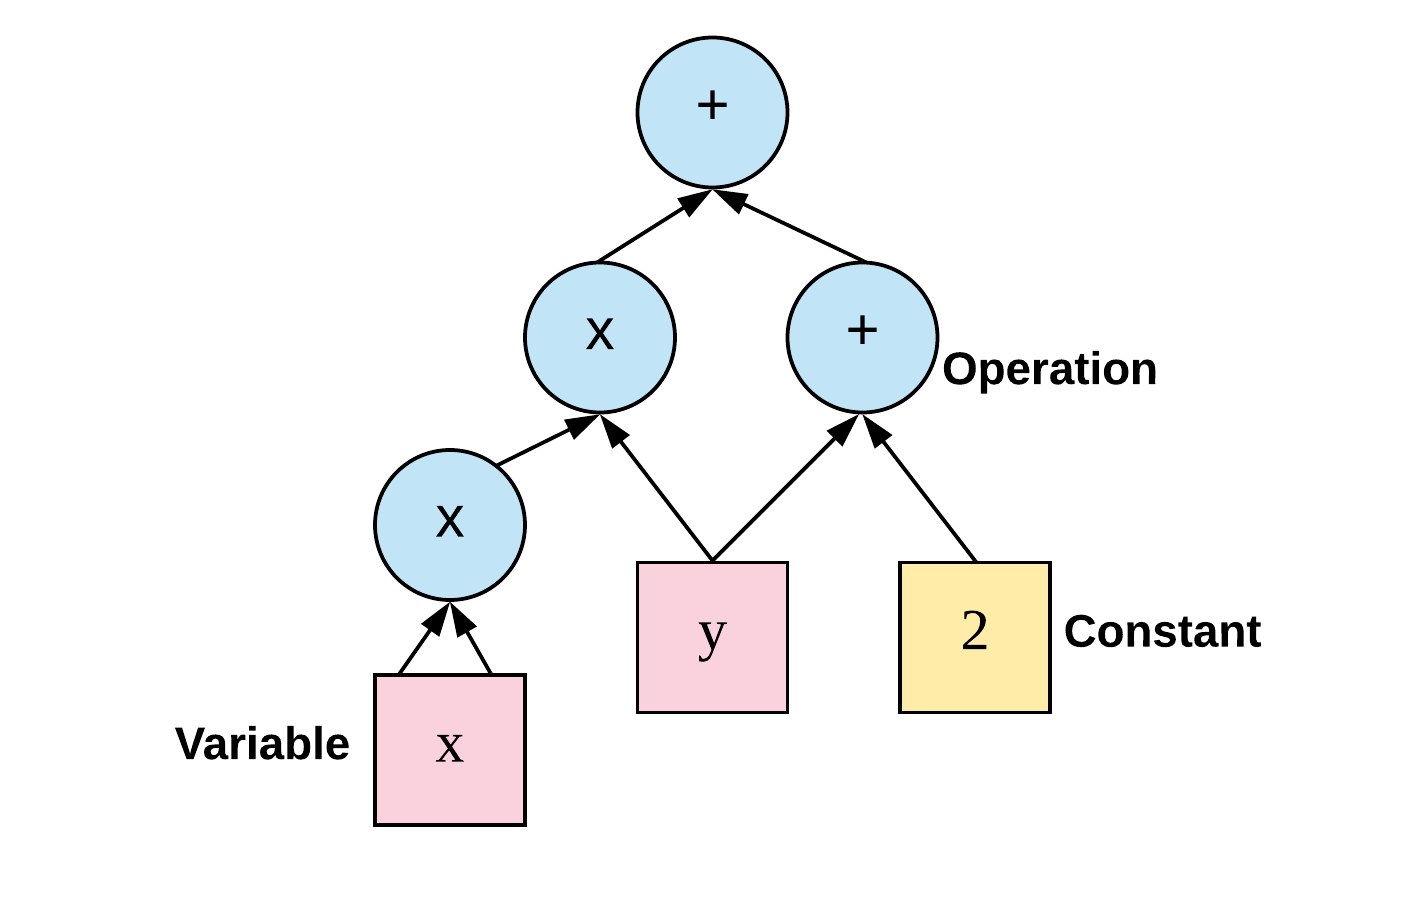

Yukarıda TensorFlow tarafından oluşturulan temsili bir graf modeli yer almaktadır. TensorFlow kodlarına veya tutoriallerine baktığınız zaman [`@tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) dekoratörünü sıklıkla göreceksiniz. 

Kısaca bu dekoratör bir python fonksiyonunu çağrılabilen bir TensorFlow grafına dönüştürür. Bu bölümün biraz detayına inelim.

TensorFlow 2.0 ile gelen [tf.function // AutoGraph](https://www.tensorflow.org/api_docs/python/tf/autograph) özelliği normal python kodlarını bir TensorFlow grafına dönüştürmeye yarar.

TensorFlow 1.X kullananlar aşağıdaki syntax'a aşinadır:
```
g = tf.Graph()
with g.as_default():
    k = tf.constant([[1,1],[2.,2.]])
    n = tf.constant([[3.,3.],[4.,4.]])
    m = tf.Variable(5.)
    l = tf.matmul(k, m) + n
    initializer = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(initializer)
    print(sess.run(l))
```    
Kısaca burada, bir graf objesi oluşturduk ve bunu `tf.Session()` içine yükledik. Yani TF 1.X kullanırken bir işlem sonucu görmek için bile graf oluşturmak gerekiyordu. TF 2.X tamamen farklı bir yaklaşım izliyor ve `eager execution`'ı varsayılan olarak aktif tutuyor. Aynı sonucu TF 2.X'te görmek için aşağıdaki kodu yazmak yeterli olacaktır:

```
k = tf.constant([[1.,1.],[2.,2.]])
n = tf.constant([[3.,3.],[4.,4.]])
m = tf.Variable(5.)
l = tf.matmul(k, m) + n

print(l.numpy())
```

TensorFlow 2.X ile:
* Graf tanımı
* Sessionlar
* `variables_initializer()` kaldırılmıştır. 

Artık yapılan herhangi bir işlemin graf tanımlamaya gerek kalmadan da görebiliriz. Sonucu direkt görebilmemiz `eager execution`'ın güzel bir yanıdır, ancak bir sorunu vardır:
* Ağır hesaplama gerektiren işlemlerde (gradient hesaplama gibi) yavaştır.

Bu yavaşlığı da `tf.function` dekoratörü ile çözebiliriz. Bu dekoratör, konuştuğumuz gibi, bir python fonksiyonunu TensorFlow graf haline çevirir. Fakat bu her fonksiyonumuzu `@tf.function` ile dekore etmeliyiz demek değildir. Basit matris işlemlerini (toplama, çıkarma) graf moduna çevirmek hız kazandırmayacaktır. Daha önce de dediğim gibi, gradient hesaplama vb işlemlerde bu yöntemi kullanacağız.

Bir model eğitirken bildiğimiz `fit()` metodunu kullanabiliriz veya kendimiz bir training loop yazarak da model eğitimi yapabiliriz. `fit()` metodundan daha hızlı eğitim yapmak istersek, işte burada `tf.function` kullanacağız. Daha önce yaptığım karşılaştırma grafiğini ekliyorum:

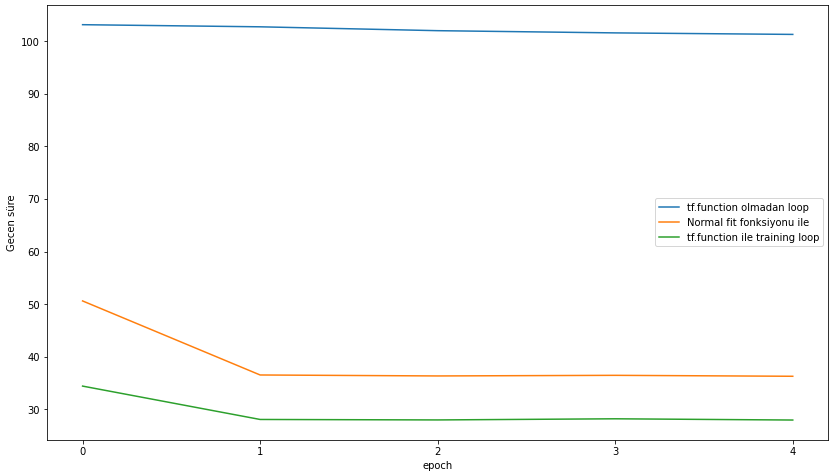

Bu grafik `tf.function` kullanıldığında `fit()` metodu ile hız karşılaştırmasını göstermektedir. `tf.function` ile model eğitim loop'unu dekore ettiğimizde ise `fit()` metodundan daha hızlı olmaktadır. Eğer ki hiç `tf.function` dekoratörü kullanmazsak, o zaman aşırı yavaş bir süreç olacaktır. Yukarda bahsettiğim gibi, `eager execution` güzeldir fakat aşırı yavaştır. Bunu da `tf.function olmadan loop` çizgisine bakıp görebiliyoruz.

Custom Training Loop ve `tf.function`'ın detaylarına daha sonraki notebooklarda bakıyor olacağız.

In [133]:
# Basit Fonksiyon
def carp(x, y):
    return x * y

@tf.function
def tf_function_carp(x, y):
    return tf.multiply(x,y)

In [135]:
x = tf.constant(np.random.uniform(10, 100), dtype = tf.float32)
y = tf.constant(np.random.uniform(10, 100), dtype = tf.float32)

In [136]:
%%timeit
carp(x,y)

70.6 µs ± 569 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [137]:
%%timeit
tf_function_carp(x,y)

402 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [138]:
# AutoGraph'ın fonksiyonumuzu nasıl convert ettiğini görmek için :)
print(tf.autograph.to_code(tf_function_carp.python_function))

def tf__tf_function_carp(x, y):
    with ag__.FunctionScope('tf_function_carp', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        try:
            do_return = True
            retval_ = ag__.converted_call(ag__.ld(tf).multiply, (ag__.ld(x), ag__.ld(y)), None, fscope)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



Bu dekoratör genelde gradient hesabı gibi işlemlerde hız kazancı sağlamaktadır.